In [19]:
%matplotlib inline
%run ../setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# notebook specific imports
import utils_funcs as utils
import pickle
import run_functions as rf
from subsets_analysis import Subsets
import copy

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

## Load and preprocess the data

In [3]:
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

In [4]:
pkl_path = '/home/jrowland/Documents/code/Vape/run_pkls/'

runs = []
for mouse in run_dict:
    for run_number in run_dict[mouse]:
        run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
        with open(run_path, 'rb') as f:
            r = pickle.load(f)
            runs.append(r)

In [5]:
# how many frames before and after the onset of lick trial to include in the kernal
pre_frames  = 5
post_frames = 9
fs = 5  # frame rate / plane

# empirally observed that 1.4 seconds after onset the artifact has gone for 150 cell trials
# offset = math.ceil(1.4*fs)

# empirally observed that offset = 4 for non-150 cell stims
offset = 4
offset

4

In [6]:
runs = [rf.filter_unhealthy_cells(run) for run in runs]
runs_s2 = [rf.select_s2(run) for run in copy.deepcopy(runs)]
runs = [utils.lick_binner(run) for run in runs]

### These are the attibutes in each run object

In [18]:
# take the first run to start
run = runs[0]

run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'flu_raw', 'frames_ms', 'frames_ms_pre', 'flu', 'spks', 'stat', 'licks', 'binned_licks_easytest'])

In [11]:
trial_licks = run.binned_licks_easytest
# the time of all the licks (in ms) that occured between trial 13 and trial 14 
# normalised to the start time of trial 13
trial_licks[13]

array([ 114,  520, 5964, 6019, 6193])

In [12]:

# build fluorescent array
flu_arr = utils.build_flu_array(run, run.trial_start, pre_frames, post_frames, use_spks=False)
# outcome of the trial
outcome = run.outcome
# how many cells were stimmed on each trial
trial_subsets = Subsets(run).trial_subsets

######## Find indexs of the trials you want to keep ###############

# hit and miss trials (go trials)
hit_miss_idx = [True if out=='hit' or out=='miss' else False for out in outcome]

# trials where the mouse is performning well
good_idx = np.full(len(outcome), False)
good_idx[rf.filter_trials(run, good=True)] = True

# trials where not-150 cells were stimmed
non_150 = trial_subsets!=150
# just 5,10,15,20 cells
small_idx = [True if t in [5, 10, 15, 20] else False for t in trial_subsets]
# just 30,40,50 cells
big_idx = [True if t in [30,40,50] else False for t in trial_subsets]
non_nan_idx = ~np.isnan(np.mean(np.mean(flu_arr, 0), 1))

# add index variables in here that you want to keep for subsequent analysis
trials_keep =  hit_miss_idx & non_nan_idx & small_idx

#index fluororesnece array with trials to keep and only take pre-stim frames 
pre_stim = flu_arr[:, trials_keep, :4]           
outcome = outcome[trials_keep]

assert pre_stim.shape[1] == len(outcome)
pre_stim.shape

(1695, 22, 4)

## Train logistic regression classifier with frame meaned data

In [13]:
# Scale frame meaned data to have 0 mean and unit variance
data = np.mean(pre_stim, 2)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(data)
data = scaler.transform(data)
print(data.shape)
print(np.nanmean(data))
print(np.nanstd(data))

(1695, 22)
-7.621804620650043e-19
1.0


In [14]:
encoder = LabelEncoder()
encoder.fit(outcome)
labels = encoder.transform(outcome)

In [15]:
clf = linear_model.LogisticRegression(max_iter=1e8, tol=1e-4, penalty='l2', solver='lbfgs')
scores = cross_val_score(clf, data.T, labels, cv=5)

print('Classification Accuracy {} +-{}'.format(round(scores.mean(),2), round(scores.std(),2)))
scores

Classification Accuracy 0.6 +-0.25


array([0.5 , 0.25, 0.5 , 1.  , 0.75])

In [16]:
# split the data with StratifiedKFold and train n classifiers on training data
# predict probabilities for test data & compute ROCs
x = data.T
y = labels

folds = 2
cv = StratifiedKFold(n_splits=folds)
classifier = linear_model.LogisticRegression(max_iter=1e8, tol=1e-5, penalty='l2',solver='lbfgs')
tprs = []
aucs = []
weights= []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x[train], y[train])
    probs = classifier.predict_proba(x[test])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test], probs)
    interp_tpr = interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucscore = roc_auc_score(y[test], probs)
    aucs.append(aucscore)
    weights.append(classifier.coef_.T)

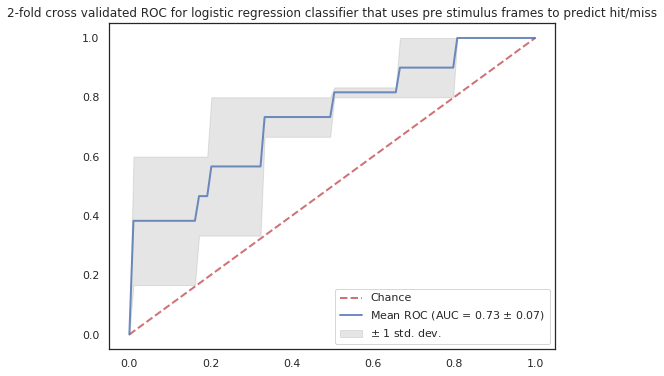

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="{}-fold cross validated ROC for logistic regression classifier that uses pre stimulus frames to predict hit/miss".format(folds))
ax.legend(loc="lower right")
plt.show()